In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import time
import math
import random
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import datasets, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.cluster import KMeans, AgglomerativeClustering
#from tensorflow.keras.datasets import cifar10 
from keras.datasets import fashion_mnist 
#from sklearn.metrics import silhouette_samples, silhouette_score

mod = sys.modules[__name__]

In [2]:
def distribution_check(dataset):
        #분포가 다름;
    one,two,three,four,five,six,seven,eight,nine,ten=0,0,0,0,0,0,0,0,0,0

    for i in range(len(dataset)):
        if(dataset[i]==1):    one+=1
        elif(dataset[i]==2):  two+=1
        elif(dataset[i]==3):  three+=1
        elif(dataset[i]==4):  four+=1
        elif(dataset[i]==5):  five+=1
        elif(dataset[i]==6):  six+=1
        elif(dataset[i]==7):  seven+=1
        elif(dataset[i]==8):  eight+=1
        elif(dataset[i]==9):  nine+=1
        elif(dataset[i]==0):  ten+=1

    #print(one,two,three,four,five,six,seven,eight,nine,ten)
    #print("Sum : ", one+two+three+four+five+six+seven+eight+nine+ten)
    sums = one+two+three+four+five+six+seven+eight+nine+ten
    for_graph=[one,two,three,four,five,six,seven,eight,nine,ten]
    
    return for_graph, sums

def local_model_generate(model): #초기 모델 생성
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

def step_function(data):
    if data > 0:
        return 1
    else:
        return 0

def sigmoid(data):
    return 1/(1+np.exp(-data))

def relu(data):
    return np.maximum(0,data)

def random_check(local, train_data, test_data):
    check_distribution_train_data, check_distribution_test_data, y_train_tmp, y_test_tmp = [], [], [], []
    sum1, sum2, data_index = 0,0, np.arange(0,10)

    for j in range(len(train_data)):
        y_train_tmp.append(np.argmax(train_data[j])) #원핫인코딩에서 다시 0~9 레이블로 변환

    for j in range(len(test_data)):
        y_test_tmp.append(np.argmax(test_data[j]))

    check_distribution_train_data, sum_train = distribution_check(y_train_tmp) #한번 밖에 실행 못함
    check_distribution_test_data, sum_test = distribution_check(y_test_tmp)
    sum1, sum2 = (sum1 + sum_train), (sum2 + sum_test)
    
    return check_distribution_train_data, check_distribution_test_data


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)
num_train, num_test = len(x_train),  len(x_test) 

(60000, 28, 28) (10000, 28, 28)


In [4]:
local = 21 # 10개 : 1~10 => 11은 포함 안됨
batch_size, epochs = 32, 5
global_epoch = 0
num_layers = 8

In [5]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("Step 1 x_train shape:", x_train.shape)

x_train = x_train.reshape((num_train, 28, 28, 1))
x_test = x_test.reshape((num_test, 28, 28, 1))

print("Step 2 x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices => one hot encoding 지금은 [3,6,2,5,4,8..] 섞여있음 

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Step 1 x_train shape: (60000, 28, 28)
Step 2 x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [6]:
global_epoch = 0

print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
    globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
    globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

    x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
    x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

    tmp, tmp2 = [], []

    num_pick = random.randint(1000, 5000) #변동 사항 #int(len(list(x_train_range))/local)
    num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
    
    tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
    tmp2 = random.sample(list(x_test_range), num_pick2)

    for i in range(len(tmp)):
        globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
        globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
        #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

    for j in range(len(tmp2)):
        globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
        globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
        #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
    
    print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

0  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  3515    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  2783    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  1131    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  1646    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1764    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  4534    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1045    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  1886    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  3820    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  2127    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4802    Number of Trainin

In [7]:
#준비된 데이터 (IID / NON-IID) np.array로

local = 21

global_epoch = 0
FedAvg_ACC, FedAvg_LOSS, fedavg_acc, fedavg_loss, acc, loss = [], [], [], [], 0, 0
num_layers_list = [0,2,4,6,7]
label_list = []

VAR_final_list_w, VAR_final_list_b = [], []


for i in range(1,local):
    globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
    globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
    globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
    globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


print("\n\n",global_epoch, "번째 global epoch에서 로컬 클라이언트 학습시작!\n\n학습 중 ...\n")
now = time.time()

for i in range(1,local):
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = models.Sequential()  ##!!!!!!! 이게 글로벌 epoch에서는 2번째 부터 들어가면 안됨
    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)] = local_model_generate(globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)])      # initialize 필요 => 모델 프레임 구축

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

    loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i,global_epoch)], globals()['L{}_y_test'.format(i)], verbose=2)
    
    fedavg_acc.append(acc)  #acc 넣기
    fedavg_loss.append(loss)  #loss 넣기


print(global_epoch, "번째 global epoch 로컬 클라이언트 학습완료!,  Total Training time : ", time.time()-now,"\n\n")

# 로컬 모델들 학습 완료하였고 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------

for i in range(1, local):
    for layer_index in num_layers_list:
        w = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성

        globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = w      # 클러스터링 용도
        globals()['L{}_layer{}_w'.format(i,layer_index)] = w          # weight aggregation 용도
            

for layer_index in num_layers_list:

    globals()['layer{}_W_tmp'.format(layer_index)] = []
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0  #FedAvg 용도
    
    globals()['var_list_layer{}_w'.format(layer_index)] = []
    globals()['var_list_layer{}_b'.format(layer_index)] = []
  
    w_scaler = 0
    #------------------------------------------------FedAvg--------------------------------------------------------
    for i in range(1, local):
        globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][0]))
        globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['L{}_layer{}_w'.format(i,layer_index)][1]))
      
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 60000
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)
    
    globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = np.array(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)]) / (local-1)   #np.array로 변함
    
    VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
    VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    
#---------------------------------------------------------메모리 삭제-------------------------------------------------------------------


FedAvg_ACC.append(fedavg_acc)
FedAvg_LOSS.append(fedavg_loss)

## G{}_num_clusters_in_layer{}_w 에 속하는 거 말고 삭제 = 메모리 낭비




 0 번째 global epoch에서 로컬 클라이언트 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.4909 - accuracy: 0.8172
15/15 - 0s - loss: 0.5019 - accuracy: 0.8067
15/15 - 0s - loss: 0.6966 - accuracy: 0.7437
15/15 - 0s - loss: 0.6632 - accuracy: 0.7500
15/15 - 0s - loss: 0.5980 - accuracy: 0.7836
15/15 - 0s - loss: 0.4776 - accuracy: 0.8340
15/15 - 0s - loss: 0.7936 - accuracy: 0.6828
15/15 - 0s - loss: 0.7310 - accuracy: 0.7458
15/15 - 0s - loss: 0.6247 - accuracy: 0.7668
15/15 - 0s - loss: 0.6341 - accuracy: 0.7542
15/15 - 0s - loss: 0.5184 - accuracy: 0.8088
15/15 - 0s - loss: 0.5756 - accuracy: 0.7752
15/15 - 0s - loss: 0.5529 - accuracy: 0.7983
15/15 - 0s - loss: 0.5987 - accuracy: 0.7878
15/15 - 0s - loss: 0.5794 - accuracy: 0.8004
15/15 - 0s - loss: 0.6173 - accuracy: 0.7815
15/15 - 0s - loss: 0.7882 - accuracy: 0.6954
15/15 - 0s - loss: 0.5515 - accuracy: 0.8004
15/15 - 0s - loss: 0.5407 - accuracy: 0.8214
15/15 - 0s - loss: 0.5522 - accuracy: 0.7815
0 번째 global epoch 로컬 클라이언트 학습완료!,  Total Training t

<ipython-input-7-9423f5a6d053>:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w'.format(i,layer_index)]) * w_scaler)


In [8]:
G_epoch = 51

for global_epoch in range(1, G_epoch):

    for layer_index in num_layers_list:
        for i in range(1, local):  #FedAvg
            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)] = globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch-1)]   #구조만 필요

            globals()['FedAvg_L{}_iter{}_model'.format(i,global_epoch)].layers[layer_index].set_weights(globals()['G{}_w_layer{}'.format(global_epoch-1, layer_index)])  #set_weights
        
  
    #----------------------------------------------------------------데이터 새로 준비----------------------------------------------------------------------------------
    print(global_epoch, " 번째 global_epoch 데이터 랜덤하게 준비!!")

    for i in range(1,local): #데이터 변수 선언, 빈 리스트로 초기화
        globals()['L{}_x_train'.format(i)], globals()['L{}_x_test'.format(i)] = [],[]  
        globals()['L{}_y_train'.format(i)], globals()['L{}_y_test'.format(i)] = [],[]  


    for n in range(1,local): #x_train_range, 잘 작동함 => 확인 완료

        x_train_range = list(np.arange(0,len(x_train)))  #0~59,999
        x_test_range = list(np.arange(0,len(x_test)))  #0~9,999

        tmp, tmp2 = [], []

        num_pick = random.randint(1000, 5000) #변동 사항 #int(len(list(x_train_range))/local)
        num_pick2 = int(len(x_test_range)/local) #test 데이터는 원래대로 항상 일정한 비율로 주면 될듯 => 어느정도 분량 이상 있어야 함
        
        tmp = random.sample(list(x_train_range), num_pick)  #1/10개 만큼 인덱스 랜덤 비복원 추출 => 랜덤으로 해야함
        tmp2 = random.sample(list(x_test_range), num_pick2)

        for i in range(len(tmp)):
            globals()['L{}_x_train'.format(n)].append(x_train[tmp[i]])  #n번째 Cluster에 분할한 실제 x_train 데이터 저장
            globals()['L{}_y_train'.format(n)].append(y_train[tmp[i]]) 
            #x_train_range.remove(tmp[i])  #랜덤 하게 뽑힌 원소갯수들 추출했으니 안에서 삭제  => 오래걸림

        for j in range(len(tmp2)):
            globals()['L{}_x_test'.format(n)].append(x_test[tmp2[j]])
            globals()['L{}_y_test'.format(n)].append(y_test[tmp2[j]])
            #x_test_range.remove(tmp2[j])  #랜덤 하게 뽑힌 원소 1000개 추출했으니 안에서 삭제  => 오래걸림
        
        print("CHECK :", n," 번째 로컬 클라이언트 Number of Training sets : ", len(globals()['L{}_x_train'.format(n)]), "   Number of Training sets : ", len(globals()['L{}_x_test'.format(n)]))

    print("check=>: should be 0 == ", len(x_train_range))  #원소 하나도 없어야 함. 확인.
    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!")

    for i in range(1,local):
        globals()['L{}_x_train'.format(i)] = np.array(globals()['L{}_x_train'.format(i)])
        globals()['L{}_x_test'.format(i)] = np.array(globals()['L{}_x_test'.format(i)])
        globals()['L{}_y_train'.format(i)] = np.array(globals()['L{}_y_train'.format(i)])
        globals()['L{}_y_test'.format(i)] = np.array(globals()['L{}_y_test'.format(i)])


    print(global_epoch, " 번째 global_epoch 데이터 랜덤 준비완료!!\n\n")

    print(global_epoch, " 번째 global epoch에서 로컬 클라이언트 들 학습시작!\n\n학습 중 ...\n")
    

    #-------------------------------------------------------------------여기가 핵심, 알고리즘 3개 따로 학습시켜야 함--------------------------------------------------------------------


    #======================================================================== FedAvg ========================================================================

    fedavg_acc, fedavg_loss, now = [],[], time.time()

    for i in range(1,local):
        # 아까 옮겨줘서 모델 그대로 compile, train 시키면 됨      
        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].fit(globals()['L{}_x_train'.format(i)], globals()['L{}_y_train'.format(i)], batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=0)

        loss, acc = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].evaluate(globals()['L{}_x_test'.format(i)], globals()['L{}_y_test'.format(i)], verbose=2)
        
        fedavg_acc.append(acc)  #acc 넣기
        fedavg_loss.append(loss)  #loss 넣기

    print("------------   ", global_epoch, " 번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time : ", time.time()-now,"---------------------------\n\n")


# 로컬 모델들 학습 완료, 로컬모델에서 weight, bias 추출 -------------------------------------------------------------------------------------


    for i in range(1, local):        
        for layer_index in num_layers_list:
            globals()['L{}_layer{}_w_tmp'.format(i,layer_index)] = globals()['FedAvg_L{}_iter{}_model'.format(i, global_epoch)].layers[layer_index].get_weights() #get_weights = w[0],b[1]로 구성, FedAvg
            
    #------------------------------------------------FedAvg--------------------------------------------------------바로 Fedavg 시키기
    
    for layer_index in num_layers_list:
        globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = 0

        globals()['var_list_layer{}_w'.format(layer_index)] = []
        globals()['var_list_layer{}_b'.format(layer_index)] = []
        w_scaler = len(globals()['L{}_x_train'.format(i)]) / 60000
        
        for i in range(1, local):
            globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)

        for i in range(1, local):
            globals()['var_list_layer{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))            
            globals()['var_list_layer{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
            
          
        VAR_final_list_w.append(globals()['var_list_layer{}_w'.format(layer_index)])
        VAR_final_list_b.append(globals()['var_list_layer{}_b'.format(layer_index)])
    

    FedAvg_ACC.append(fedavg_acc)
    FedAvg_LOSS.append(fedavg_loss)

    print("\n\n====================================================== One Global Epoch =====================================================================\n\n")

1  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  2634    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  4625    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  3068    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  1684    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  4072    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  3545    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1843    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  4736    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  3705    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  3671    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  2980    Number of Trainin

<ipython-input-8-e58c13c18cea>:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] = globals()['G{}_w_layer{}'.format(global_epoch, layer_index)] + (np.array(globals()['L{}_layer{}_w_tmp'.format(i,layer_index)])*w_scaler)


CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  3475    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2001    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1951    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  4101    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  3246    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  3464    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4849    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  2912    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  4875    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  3145    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  4881    Number of Training sets :  476
CHECK : 16  번째 

15/15 - 0s - loss: 0.6505 - accuracy: 0.7437
15/15 - 0s - loss: 0.6509 - accuracy: 0.7731
15/15 - 0s - loss: 0.6973 - accuracy: 0.7038
15/15 - 0s - loss: 0.6525 - accuracy: 0.7563
15/15 - 0s - loss: 0.7114 - accuracy: 0.7374
15/15 - 0s - loss: 0.6586 - accuracy: 0.7668
15/15 - 0s - loss: 0.5859 - accuracy: 0.7878
15/15 - 0s - loss: 0.6180 - accuracy: 0.7689
15/15 - 0s - loss: 0.6750 - accuracy: 0.7773
15/15 - 0s - loss: 0.6440 - accuracy: 0.7521
15/15 - 0s - loss: 0.7074 - accuracy: 0.7248
15/15 - 0s - loss: 0.6653 - accuracy: 0.7500
15/15 - 0s - loss: 0.8396 - accuracy: 0.7059
------------    4  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  196.46766877174377 ---------------------------




====================================================== One Global Epoch =====================================================================


5  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  4176    Number of Training sets :  476
CHECK : 2  

CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  1228    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  3973    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  1081    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  2864    Number of Training sets :  476
check=>: should be 0 ==  60000
7  번째 global_epoch 데이터 랜덤 준비완료!!
7  번째 global_epoch 데이터 랜덤 준비완료!!


7  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.5252 - accuracy: 0.8067
15/15 - 0s - loss: 0.6454 - accuracy: 0.7542
15/15 - 0s - loss: 0.4957 - accuracy: 0.8046
15/15 - 0s - loss: 0.5409 - accuracy: 0.7983
15/15 - 0s - loss: 0.5647 - accuracy: 0.8067
15/15 - 0s - loss: 0.4803 - accuracy: 0.8172
15/15 - 0s - loss: 0.4774 - accuracy: 0.8130
15/15 - 0s - loss: 0.5326 - accuracy: 0.8067
15/15 - 0s - loss: 0.6173 - accuracy: 0.7899
15/15 - 0s - loss: 0.5540 - accuracy: 0.7941
15/15 - 0s - loss: 0.6168 - accuracy: 0.76

CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  3451    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1904    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  3725    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  3034    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  4249    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  2058    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  2511    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  1720    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  2856    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  3278    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  3548    Number of Training sets :  476
CHECK : 17  번째

15/15 - 0s - loss: 0.4784 - accuracy: 0.8340
15/15 - 0s - loss: 0.4384 - accuracy: 0.8340
15/15 - 0s - loss: 0.4592 - accuracy: 0.8319
15/15 - 0s - loss: 0.5202 - accuracy: 0.8025
15/15 - 0s - loss: 0.4849 - accuracy: 0.8109
15/15 - 0s - loss: 0.4841 - accuracy: 0.8319
15/15 - 0s - loss: 0.5830 - accuracy: 0.8046
15/15 - 0s - loss: 0.5147 - accuracy: 0.8088
15/15 - 0s - loss: 0.4261 - accuracy: 0.8424
15/15 - 0s - loss: 0.4741 - accuracy: 0.8445
15/15 - 0s - loss: 0.5206 - accuracy: 0.8046
------------    12  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  189.08674502372742 ---------------------------




====================================================== One Global Epoch =====================================================================


13  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  1690    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  1444    Number of Training sets :  476
CHECK : 3 

CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  1550    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  1364    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  1759    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  4259    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  1811    Number of Training sets :  476
check=>: should be 0 ==  60000
15  번째 global_epoch 데이터 랜덤 준비완료!!
15  번째 global_epoch 데이터 랜덤 준비완료!!


15  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.4537 - accuracy: 0.8319
15/15 - 0s - loss: 0.4443 - accuracy: 0.8382
15/15 - 0s - loss: 0.4929 - accuracy: 0.8067
15/15 - 0s - loss: 0.5503 - accuracy: 0.7962
15/15 - 0s - loss: 0.4365 - accuracy: 0.8214
15/15 - 0s - loss: 0.4831 - accuracy: 0.8067
15/15 - 0s - loss: 0.5930 - accuracy: 0.7773
15/15 - 0s - loss: 0.5213 - accuracy: 0.8109
15/15 - 0s - loss: 0.4589 - accuracy: 0

CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  3556    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  2266    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  1516    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  2973    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  3460    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  3472    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  1880    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  3861    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  1854    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  3519    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  3741    Number of Training sets :  476
CHECK : 15  번째 로

15/15 - 0s - loss: 0.5253 - accuracy: 0.8361
15/15 - 0s - loss: 0.5934 - accuracy: 0.8403
15/15 - 0s - loss: 0.4118 - accuracy: 0.8655
15/15 - 0s - loss: 0.5672 - accuracy: 0.8361
15/15 - 0s - loss: 0.4874 - accuracy: 0.8592
15/15 - 0s - loss: 0.6227 - accuracy: 0.8508
15/15 - 0s - loss: 0.7179 - accuracy: 0.7983
15/15 - 0s - loss: 0.5912 - accuracy: 0.8298
15/15 - 0s - loss: 0.4388 - accuracy: 0.8613
15/15 - 0s - loss: 0.4036 - accuracy: 0.8424
15/15 - 0s - loss: 0.4461 - accuracy: 0.8550
15/15 - 0s - loss: 0.5038 - accuracy: 0.8487
15/15 - 0s - loss: 0.4240 - accuracy: 0.8803
15/15 - 0s - loss: 0.5479 - accuracy: 0.8361
15/15 - 0s - loss: 0.5725 - accuracy: 0.8340
------------    20  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  178.2028889656067 ---------------------------




====================================================== One Global Epoch =====================================================================


21  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1

CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  3893    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  1160    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  4461    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  2447    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  1635    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  2920    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  3818    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  4386    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  2168    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  2369    Number of Training sets :  476
check=>: should be 0 ==  60000
23  번째 global_epoch 데이터 랜덤 준비완료!!
23  번째 global_epoch 데이터 랜덤 준비완료!!



15/15 - 0s - loss: 0.3892 - accuracy: 0.8634
------------    25  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  174.911315202713 ---------------------------




====================================================== One Global Epoch =====================================================================


26  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  1819    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  1689    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  4213    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  4224    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  2457    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  2225    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  1396    Number of Training sets :  476
CHECK : 8  번째 로컬 

CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  4715    Number of Training sets :  476
check=>: should be 0 ==  60000
28  번째 global_epoch 데이터 랜덤 준비완료!!
28  번째 global_epoch 데이터 랜덤 준비완료!!


28  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.6337 - accuracy: 0.8403
15/15 - 0s - loss: 0.7450 - accuracy: 0.8466
15/15 - 0s - loss: 0.5861 - accuracy: 0.8445
15/15 - 0s - loss: 0.6461 - accuracy: 0.8403
15/15 - 0s - loss: 0.4482 - accuracy: 0.8718
15/15 - 0s - loss: 0.4223 - accuracy: 0.8550
15/15 - 0s - loss: 0.6393 - accuracy: 0.8613
15/15 - 0s - loss: 0.6599 - accuracy: 0.8571
15/15 - 0s - loss: 0.4532 - accuracy: 0.8739
15/15 - 0s - loss: 0.6859 - accuracy: 0.8466
15/15 - 0s - loss: 0.5409 - accuracy: 0.8424
15/15 - 0s - loss: 0.4581 - accuracy: 0.8424
15/15 - 0s - loss: 0.3723 - accuracy: 0.8845
15/15 - 0s - loss: 0.6869 - accuracy: 0.8424
15/15 - 0s - loss: 0.4409 - accuracy: 0.8487
15/15 - 0s - loss: 0.5689 - accuracy: 0.8403
15/15 - 0s - loss: 0.4459 - accuracy: 0

CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1263    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  1033    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  3550    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  3028    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  1026    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  3033    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  4590    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  3403    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  1391    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  4331    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  4498    Number of Training sets :  476
CHECK : 20 

15/15 - 0s - loss: 1.0058 - accuracy: 0.8193
15/15 - 0s - loss: 0.8062 - accuracy: 0.8277
15/15 - 0s - loss: 1.3359 - accuracy: 0.8256
15/15 - 0s - loss: 0.8499 - accuracy: 0.8256
15/15 - 0s - loss: 0.8722 - accuracy: 0.8319
------------    33  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  297.7523407936096 ---------------------------




====================================================== One Global Epoch =====================================================================


34  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  3358    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  3565    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  2761    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  3948    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  2546    Number of Training sets :  476
CHECK : 6  번째 

CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  3846    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  4004    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  3317    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  1700    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  2418    Number of Training sets :  476
check=>: should be 0 ==  60000
36  번째 global_epoch 데이터 랜덤 준비완료!!
36  번째 global_epoch 데이터 랜덤 준비완료!!


36  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.4572 - accuracy: 0.8676
15/15 - 0s - loss: 0.4168 - accuracy: 0.8803
15/15 - 0s - loss: 0.5690 - accuracy: 0.8382
15/15 - 0s - loss: 0.5223 - accuracy: 0.8676
15/15 - 0s - loss: 0.6341 - accuracy: 0.8319
15/15 - 0s - loss: 0.5520 - accuracy: 0.8571
15/15 - 0s - loss: 0.5014 - accuracy: 0.8550
15/15 - 0s - loss: 0.3979 - accuracy: 0.8697
15/15 - 0s - loss: 0.3795 - accuracy: 0

CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  3106    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  4036    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  1081    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  4640    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  3835    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  4489    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1614    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  3776    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4444    Number of Training sets :  476
CHECK : 12  번째 로컬 클라이언트 Number of Training sets :  1136    Number of Training sets :  476
CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  1970    Number of Training sets :  476
CHECK : 14  번째 로컬

15/15 - 0s - loss: 0.3649 - accuracy: 0.8739
15/15 - 0s - loss: 0.5112 - accuracy: 0.8193
15/15 - 0s - loss: 0.3889 - accuracy: 0.8676
15/15 - 0s - loss: 0.3889 - accuracy: 0.8571
15/15 - 0s - loss: 0.4238 - accuracy: 0.8466
15/15 - 0s - loss: 0.3961 - accuracy: 0.8550
15/15 - 0s - loss: 0.3316 - accuracy: 0.8866
15/15 - 0s - loss: 0.4903 - accuracy: 0.8151
15/15 - 0s - loss: 0.3485 - accuracy: 0.8803
15/15 - 0s - loss: 0.4287 - accuracy: 0.8676
15/15 - 0s - loss: 0.3182 - accuracy: 0.8739
15/15 - 0s - loss: 0.4210 - accuracy: 0.8634
15/15 - 0s - loss: 0.3735 - accuracy: 0.8676
15/15 - 0s - loss: 0.3594 - accuracy: 0.8466
15/15 - 0s - loss: 0.4489 - accuracy: 0.8424
15/15 - 0s - loss: 0.3919 - accuracy: 0.8592
15/15 - 0s - loss: 0.3788 - accuracy: 0.8634
------------    41  번째 global epoch < FedAVG > 로컬 클라이언트 학습 완료!,  Total Training time :  352.4990577697754 ---------------------------




====================================================== One Global Epoch =========================

CHECK : 13  번째 로컬 클라이언트 Number of Training sets :  1491    Number of Training sets :  476
CHECK : 14  번째 로컬 클라이언트 Number of Training sets :  3541    Number of Training sets :  476
CHECK : 15  번째 로컬 클라이언트 Number of Training sets :  2389    Number of Training sets :  476
CHECK : 16  번째 로컬 클라이언트 Number of Training sets :  2959    Number of Training sets :  476
CHECK : 17  번째 로컬 클라이언트 Number of Training sets :  2435    Number of Training sets :  476
CHECK : 18  번째 로컬 클라이언트 Number of Training sets :  1199    Number of Training sets :  476
CHECK : 19  번째 로컬 클라이언트 Number of Training sets :  1641    Number of Training sets :  476
CHECK : 20  번째 로컬 클라이언트 Number of Training sets :  1564    Number of Training sets :  476
check=>: should be 0 ==  60000
44  번째 global_epoch 데이터 랜덤 준비완료!!
44  번째 global_epoch 데이터 랜덤 준비완료!!


44  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.3951 - accuracy: 0.8655
15/15 - 0s - loss: 0.4722 - accuracy: 0.8529
15/15 - 0s - loss: 0.5146 - accuracy: 0

47  번째 global_epoch 데이터 랜덤하게 준비!!
CHECK : 1  번째 로컬 클라이언트 Number of Training sets :  1701    Number of Training sets :  476
CHECK : 2  번째 로컬 클라이언트 Number of Training sets :  4986    Number of Training sets :  476
CHECK : 3  번째 로컬 클라이언트 Number of Training sets :  1554    Number of Training sets :  476
CHECK : 4  번째 로컬 클라이언트 Number of Training sets :  3397    Number of Training sets :  476
CHECK : 5  번째 로컬 클라이언트 Number of Training sets :  3737    Number of Training sets :  476
CHECK : 6  번째 로컬 클라이언트 Number of Training sets :  4990    Number of Training sets :  476
CHECK : 7  번째 로컬 클라이언트 Number of Training sets :  4397    Number of Training sets :  476
CHECK : 8  번째 로컬 클라이언트 Number of Training sets :  3178    Number of Training sets :  476
CHECK : 9  번째 로컬 클라이언트 Number of Training sets :  1212    Number of Training sets :  476
CHECK : 10  번째 로컬 클라이언트 Number of Training sets :  2825    Number of Training sets :  476
CHECK : 11  번째 로컬 클라이언트 Number of Training sets :  4762    Number of Traini

49  번째 global_epoch 데이터 랜덤 준비완료!!


49  번째 global epoch에서 로컬 클라이언트 들 학습시작!

학습 중 ...

15/15 - 0s - loss: 0.4063 - accuracy: 0.8592
15/15 - 0s - loss: 0.5075 - accuracy: 0.8340
15/15 - 0s - loss: 0.4907 - accuracy: 0.8340
15/15 - 0s - loss: 0.5811 - accuracy: 0.8340
15/15 - 0s - loss: 0.4352 - accuracy: 0.8340
15/15 - 0s - loss: 0.4977 - accuracy: 0.8256
15/15 - 0s - loss: 0.4855 - accuracy: 0.8403
15/15 - 0s - loss: 0.4887 - accuracy: 0.8445
15/15 - 0s - loss: 0.6718 - accuracy: 0.8298
15/15 - 0s - loss: 0.3886 - accuracy: 0.8487
15/15 - 0s - loss: 0.6390 - accuracy: 0.8067
15/15 - 0s - loss: 0.4332 - accuracy: 0.8361
15/15 - 0s - loss: 0.5020 - accuracy: 0.8403
15/15 - 0s - loss: 0.5748 - accuracy: 0.8361
15/15 - 0s - loss: 0.4879 - accuracy: 0.8508
15/15 - 0s - loss: 0.5080 - accuracy: 0.8571
15/15 - 0s - loss: 0.3842 - accuracy: 0.8676
15/15 - 0s - loss: 0.4712 - accuracy: 0.8697
15/15 - 0s - loss: 0.5853 - accuracy: 0.8445
15/15 - 0s - loss: 0.5223 - accuracy: 0.8382
------------  

Variance Accumulate Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------


Var Accumulate Weight
--------------------------------------
[1.3814808e-06, 3.7262726e-06, 0.0020933582, 0.015556488, 0.011864399, 0.011563524, 0.016357927, 0.021966197, 0.018215904, 0.036567584, 0.01410364, 0.037957672, 0.066075556, 0.014959316, 0.014608307, 0.009190669, 0.02534289, 0.021314254, 0.058807135, 0.13031569, 0.09850134, 0.022589846, 0.031862885, 0.023661293, 0.036819275, 0.038420327, 0.108797565, 0.1553872, 0.3805308, 0.07079339, 0.1843088, 0.49025896, 0.5486946, 0.7873566, 1.3069847, 0.17764033, 0.11406183, 0.17668186, 0.32218364, 0.099803, 0.04004443, 0.019867975, 0.011240948, 0.014885586, 0.006270702, 0.00795199, 0.0018117452, 0.019913651, 0.05383552]
[4.8733614e-07, 5.822477e-07, 0.00033560558, 0.0050323014, 0.0030670005, 0.0030503955, 0.004341065, 0.005385229, 0.0039925273, 0.007665563, 0.0026216833, 0.008043695, 0.012554538, 0.0026

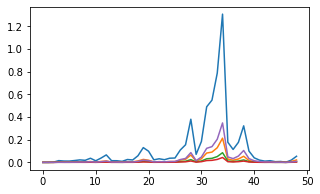

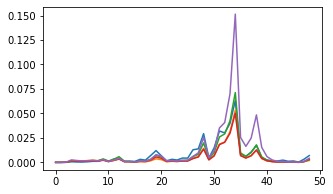

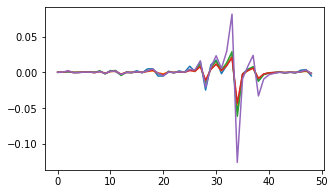

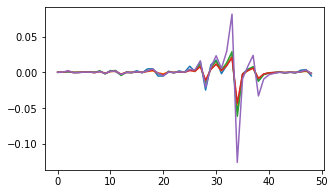

In [9]:
var_changes_L0_w, var_changes_L2_w, var_changes_L4_w, var_changes_L6_w, var_changes_L7_w = [], [], [], [], [] 
var_accumulate_L0_w, var_accumulate_L2_w, var_accumulate_L4_w, var_accumulate_L6_w, var_accumulate_L7_w = [], [], [], [], [] 

var_changes_L0_b, var_changes_L2_b, var_changes_L4_b, var_changes_L6_b, var_changes_L7_b = [], [], [], [], [] 
var_accumulate_L0_b, var_accumulate_L2_b, var_accumulate_L4_b, var_accumulate_L6_b, var_accumulate_L7_b = [], [], [], [], [] 


for global_epoch in range(G_epoch-2):
    for layer_index in num_layers_list:
        globals()['var_accumulate_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        globals()['var_changes_L{}_w'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][0]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][0]))
        
        globals()['var_accumulate_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        globals()['var_changes_L{}_b'.format(layer_index)].append(np.var(globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)][1]) - np.var(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)][1]))
        

print("Variance Accumulate Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Accumulate Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_w'.format(j)])

print("\nVar Accumulate Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_accumulate_L{}_b'.format(j)])

print("\n\nVariance Change Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------\n")

print("\nVar Changes Weight\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_w'.format(j)])

print("\nVar Changes Bias\n--------------------------------------")
for j in num_layers_list:
    print(globals()['var_changes_L{}_b'.format(j)])



print("\nNow Check the graph\n")

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_w'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_accumulate_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])

plt.figure(figsize=(5,3))
for j in num_layers_list:
    plt.plot(globals()['var_changes_L{}_b'.format(j)])


Distance Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[0.0017341586, 0.046391018, 0.08156031, 0.038093135, 0.013723632, 0.019122515, 0.019166201, 0.017063389, 0.04447517, 0.05880895, 0.06710649, 0.03999655, 0.10018125, 0.020556152, 0.016670613, 0.05594929, 0.020190915, 0.07724048, 0.080368616, 0.048172016, 0.116388746, 0.032655798, 0.02045875, 0.03290626, 0.007199036, 0.100364774, 0.040155403, 0.1482449, 0.24969196, 0.11860403, 0.17628676, 0.034628354, 0.09433934, 0.16547394, 0.47238758, 0.058068916, 0.05868365, 0.09277166, 0.16594285, 0.07284447, 0.03645423, 0.023220215, 0.022880139, 0.033218708, 0.01679694, 0.040814254, 0.0996725, 0.07001998, 0.076586515]
[0.0010613686, 0.016593056, 0.07262242, 0.021970225, 0.010313084, 0.013510823, 0.01042572, 0.016648121, 0.025381826, 0.041533303, 0.03783746, 0.024676014, 0.061677728, 0.011894578, 0.013390889, 0.029684484, 0.0136422645, 0.03676341, 0.041377258, 0.023872385, 0.060

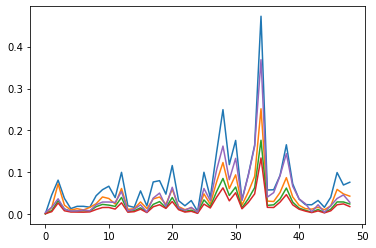

In [10]:
from scipy.spatial import distance

dist_0, dist_2, dist_4, dist_6, dist_7  = [], [], [], [], []

for global_epoch in range(G_epoch-2):
    for layer_index in num_layers_list:
        globals()['dist_{}'.format(layer_index)].append(np.mean(distance.euclidean(globals()['G{}_w_layer{}'.format(global_epoch, layer_index)], globals()['G{}_w_layer{}'.format(global_epoch+1, layer_index)])))



print("Distance Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(dist_0)
print(dist_2)
print(dist_4)
print(dist_6)
print(dist_7, "\n\nCheck the graph\n")

plt.plot(dist_0)
plt.plot(dist_2)
plt.plot(dist_4)
plt.plot(dist_6)
plt.plot(dist_7)

plt.show()

Average Acc and Loss Layer 0,2,4,6,7
--------------------------------------------------------------------------------------------------
[[0.8172268867492676, 0.8067227005958557, 0.743697464466095, 0.75, 0.7836134433746338, 0.8340336084365845, 0.6827731132507324, 0.7457982897758484, 0.7668067216873169, 0.7542017102241516, 0.8088235259056091, 0.7752100825309753, 0.7983193397521973, 0.7878151535987854, 0.8004201650619507, 0.7815126180648804, 0.6953781247138977, 0.8004201650619507, 0.8214285969734192, 0.7815126180648804], [0.09663865715265274, 0.09663865715265274, 0.08193277567625046, 0.09663865715265274, 0.09243697673082352, 0.09663865715265274, 0.09243697673082352, 0.0903361365199089, 0.11344537883996964, 0.09453781694173813, 0.09453781694173813, 0.09453781694173813, 0.09663865715265274, 0.6302521228790283, 0.10084033757448196, 0.09663865715265274, 0.0903361365199089, 0.10924369841814041, 0.08193277567625046, 0.08403361588716507], [0.6239495873451233, 0.6029411554336548, 0.67857140302658

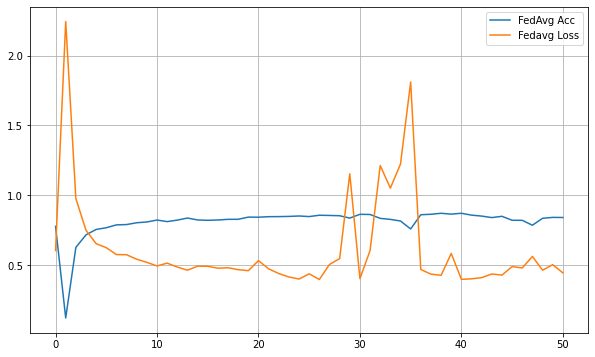

In [11]:
average_acc_list, average_loss_list = [], []


for i in range(len(FedAvg_ACC)):
    average_acc_list.append(np.mean(FedAvg_ACC[i]))
    average_loss_list.append(np.mean(FedAvg_LOSS[i]))
    

print("Average Acc and Loss Layer 0,2,4,6,7\n--------------------------------------------------------------------------------------------------")
print(FedAvg_ACC)
print(FedAvg_LOSS)
print("\n\n Now Check the graph\n")

plt.figure(figsize=(10,6))
plt.plot(average_acc_list, label='FedAvg Acc')

plt.plot(average_loss_list, label='Fedavg Loss')

plt.grid(True)
plt.legend()
plt.show()
